<a href="https://colab.research.google.com/github/Anfiyasharaf/anfiya/blob/main/skin_disease_usin_Skin_cancerdence_Net_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

train_dir = '/content/drive/MyDrive/archive (1)/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/drive/MyDrive/archive (1)/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

<ipython-input-3-a79f037fee76>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-3-a79f037fee76>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-3-a79f037fee76>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-3-a79f037fee76>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_pa

image_path label
0     /content/drive/MyDrive/archive (1)/Skin cancer...     0
1     /content/drive/MyDrive/archive (1)/Skin cancer...     0
2     /content/drive/MyDrive/archive (1)/Skin cancer...     0
3     /content/drive/MyDrive/archive (1)/Skin cancer...     0
4     /content/drive/MyDrive/archive (1)/Skin cancer...     0
...                                                 ...   ...
2352  /content/drive/MyDrive/archive (1)/Skin cancer...     8
2353  /content/drive/MyDrive/archive (1)/Skin cancer...     8
2354  /content/drive/MyDrive/archive (1)/Skin cancer...     8
2355  /content/drive/MyDrive/archive (1)/Skin cancer...     8
2356  /content/drive/MyDrive/archive (1)/Skin cancer...     8

[2357 rows x 2 columns]

In [ ]:

labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'basal cell carcinoma',
 1: 'dermatofibroma',
 2: 'pigmented benign keratosis',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'nevus',
 6: 'seborrheic keratosis',
 7: 'melanoma',
 8: 'vascular lesion'}

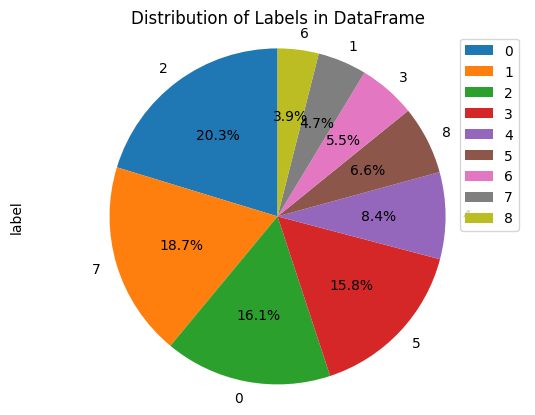

In [ ]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [ ]:
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               basal cell carcinoma           379       
1               dermatofibroma                 111       
2               pigmented benign keratosis     478       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               nevus                          373       
6               seborrheic keratosis           93        
7               melanoma                       441       
8               vascular lesion                155       
------------------------------------------------------------
Total                                         2357      


In [ ]:
max_images_per_class = 2500


df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

<ipython-input-7-8ca9210f4584>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [ ]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
df = df.groupby("label", group_keys=False).apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [ ]:
import tensorflow as tf

# Allow GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except Exception as ex:
    print(ex)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
'bool' object is not callable


In [ ]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

2

In [ ]:
import concurrent.futures


def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

try:

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:

        image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))


    df['image'] = image_arrays
    del image_arrays

except KeyboardInterrupt:
    # Handle keyboard interrupt gracefully
    print("Resizing process interrupted.")

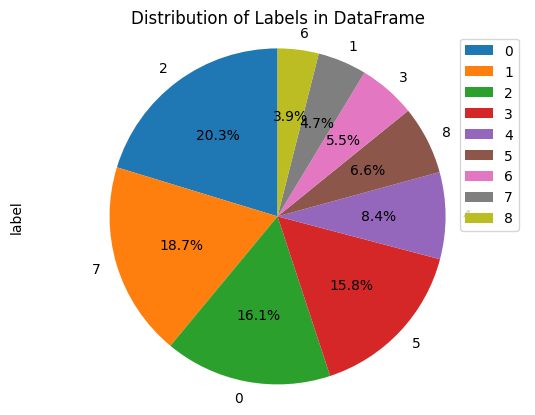

In [ ]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [ ]:
df.head()

image_path label  \
0  /content/drive/MyDrive/archive (1)/Skin cancer...     0   
1  /content/drive/MyDrive/archive (1)/Skin cancer...     0   
2  /content/drive/MyDrive/archive (1)/Skin cancer...     0   
3  /content/drive/MyDrive/archive (1)/Skin cancer...     0   
4  /content/drive/MyDrive/archive (1)/Skin cancer...     0   

                                               image  
0  [[[204, 188, 193], [206, 188, 192], [207, 190,...  
1  [[[172, 152, 161], [169, 148, 158], [170, 151,...  
2  [[[190, 178, 186], [194, 184, 193], [191, 179,...  
3  [[[62, 44, 44], [86, 64, 62], [113, 88, 88], [...  
4  [[[179, 139, 140], [183, 146, 145], [182, 144,...

In [ ]:
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               basal cell carcinoma           379       
1               dermatofibroma                 111       
2               pigmented benign keratosis     478       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               nevus                          373       
6               seborrheic keratosis           93        
7               melanoma                       441       
8               vascular lesion                155       
------------------------------------------------------------
Total                                         2357      


In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    2357
Name: image, dtype: int64

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)

            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)

    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-18-bbe11ad40ae2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-18-bbe11ad40ae2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-18-bbe11ad40ae2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-18-bbe11ad40ae2>:27: FutureWarn

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               nevus                          2500      
1               pigmented benign keratosis     2500      
2               actinic keratosis              2500      
3               basal cell carcinoma           2500      
4               vascular lesion                2500      
5               dermatofibroma                 2500      
6               squamous cell carcinoma        2500      
7               melanoma                       2500      
8               seborrheic keratosis           2500      
------------------------------------------------------------
Total                                         22500     


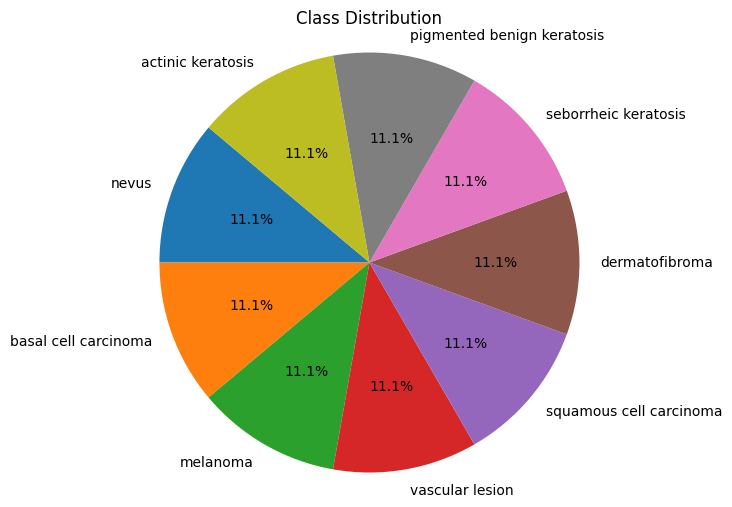

In [ ]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame 'df' properly

class_counts = df['label'].value_counts()

label_map = {
0 :'nevus',
1 :'pigmented benign keratosis',
2 :'actinic keratosis',
3 :'basal cell carcinoma',
4 :'vascular lesion',
5 :'dermatofibroma',
6 :'squamous cell carcinoma',
7 :'melanoma',
8 :'seborrheic keratosis',
}

# Display dataset summary
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts.get(class_label, 0)
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

# Create a pie chart
plt.figure(figsize=(8, 6))
# Filter out labels that are not in label_map
filtered_labels = [label for label in class_counts.index if label in label_map]
plt.pie(class_counts[filtered_labels], labels=[label_map[label] for label in filtered_labels], autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution")
plt.axis('equal')
plt.show()


In [ ]:
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               nevus                          2500      
1               pigmented benign keratosis     2500      
2               actinic keratosis              2500      
3               basal cell carcinoma           2500      
4               vascular lesion                2500      
5               dermatofibroma                 2500      
6               squamous cell carcinoma        2500      
7               melanoma                       2500      
8               seborrheic keratosis           2500      
------------------------------------------------------------
Total                                         22500     


In [ ]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [ ]:
features.head()

image
0  [[[26, 19, 24], [38, 31, 35], [61, 49, 50], [8...
1  [[[202, 163, 177], [200, 159, 172], [195, 153,...
2  [[[248, 237, 205], [245, 230, 192], [242, 221,...
3  [[[164, 104, 110], [163, 103, 109], [163, 103,...
4  [[[168, 121, 120], [168, 121, 120], [168, 121,...

In [ ]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: object

In [ ]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [ ]:
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               nevus                          1586       409          505        2500      
1               pigmented benign keratosis     1587       394          519        2500      
2               actinic keratosis              1606       377          517        2500      
3               basal cell carcinoma           1582       398          520        2500      
4               vascular lesion                1611       407          482        2500      
5               dermatofibroma                 1640       373          487        2500      
6               squamous cell carcinoma        1589       398          513        2500      
7               melanoma                       1607       

In [ ]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for i, class_label in enumerate(label_map):
    class_name = label_map[class_label]
    train_num = int(train_counts[i])
    val_num = int(val_counts[i])
    test_num = int(test_counts[i])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
total_train = np.sum(train_counts)
total_val = np.sum(val_counts)
total_test = np.sum(test_counts)
total_images = total_train + total_val + total_test
print(f"{'Total':<46} {total_train:<10} {total_val:<12} {total_test:<10} {total_images:<10}")




Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               nevus                          1586       409          505        2500      
1               pigmented benign keratosis     1587       394          519        2500      
2               actinic keratosis              1606       377          517        2500      
3               basal cell carcinoma           1582       398          520        2500      
4               vascular lesion                1611       407          482        2500      
5               dermatofibroma                 1640       373          487        2500      
6               squamous cell carcinoma        1589       398          513        2500      
7               melanoma                       1607       

In [ ]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [ ]:
input_shape = df['image'][0].shape

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24,225,353
Trainable params: 23,996,297
Non-trainable params: 229,056
_______________________________________

In [ ]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)

In [ ]:
epochs = 15


batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)


Epoch 1/15
450/450 [==============================] - ETA: 0s - loss: 1.9237 - accuracy: 0.3492

450/450 [==============================] - 99s 136ms/step - loss: 1.9237 - accuracy: 0.3492 - val_loss: 1.2901 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 2/15
450/450 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.5572

450/450 [==============================] - 56s 124ms/step - loss: 1.2572 - accuracy: 0.5572 - val_loss: 0.9921 - val_accuracy: 0.6469 - lr: 1.0000e-04
Epoch 3/15
450/450 [==============================] - ETA: 0s - loss: 0.9710 - accuracy: 0.6527

450/450 [==============================] - 56s 123ms/step - loss: 0.9710 - accuracy: 0.6527 - val_loss: 0.7987 - val_accuracy: 0.7133 - lr: 1.0000e-04
Epoch 4/15
450/450 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.7220

450/450 [==============================] - 55s 123ms/step - loss: 0.7694 - accuracy: 0.7220 - val_loss: 0.6777 - val_accuracy: 0.7567 - lr: 1.0000e-04
Epoch 5/15
450/450 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.7759

450/450 [==============================] - 57s 126ms/step - loss: 0.6141 - accuracy: 0.7759 - val_loss: 0.6013 - val_accuracy: 0.7822 - lr: 1.0000e-04
Epoch 6/15
450/450 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.8226

450/450 [==============================] - 57s 127ms/step - loss: 0.4917 - accuracy: 0.8226 - val_loss: 0.5228 - val_accuracy: 0.8161 - lr: 1.0000e-04
Epoch 7/15
450/450 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8617

450/450 [==============================] - 57s 126ms/step - loss: 0.3866 - accuracy: 0.8617 - val_loss: 0.4988 - val_accuracy: 0.8275 - lr: 1.0000e-04
Epoch 8/15
450/450 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8886

450/450 [==============================] - 57s 126ms/step - loss: 0.3112 - accuracy: 0.8886 - val_loss: 0.4440 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 9/15
450/450 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9077

450/450 [==============================] - 57s 126ms/step - loss: 0.2582 - accuracy: 0.9077 - val_loss: 0.4275 - val_accuracy: 0.8472 - lr: 1.0000e-04
Epoch 10/15
450/450 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9237

450/450 [==============================] - 56s 125ms/step - loss: 0.2142 - accuracy: 0.9237 - val_loss: 0.4173 - val_accuracy: 0.8606 - lr: 1.0000e-04
Epoch 11/15
450/450 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9390

450/450 [==============================] - 57s 127ms/step - loss: 0.1747 - accuracy: 0.9390 - val_loss: 0.4159 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 12/15
450/450 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9447

450/450 [==============================] - 57s 126ms/step - loss: 0.1563 - accuracy: 0.9447 - val_loss: 0.4256 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 13/15
450/450 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9565

450/450 [==============================] - 57s 126ms/step - loss: 0.1311 - accuracy: 0.9565 - val_loss: 0.4226 - val_accuracy: 0.8689 - lr: 1.0000e-04
Epoch 14/15
450/450 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9624

450/450 [==============================] - 57s 127ms/step - loss: 0.1113 - accuracy: 0.9624 - val_loss: 0.4362 - val_accuracy: 0.8719 - lr: 1.0000e-04
Epoch 15/15
450/450 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9668

450/450 [==============================] - 57s 127ms/step - loss: 0.0982 - accuracy: 0.9668 - val_loss: 0.4361 - val_accuracy: 0.8717 - lr: 1.0000e-04


In [ ]:
model.save("skinDiseaseDetectionUsningCNN.h5")


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained classification model
model = load_model('/content/skinDiseaseDetectionUsningCNN.h5')  # Load your model file

# Load and preprocess test images
test_image_paths = ['/content/ISIC_0000003.jpg', '/content/ISIC_0000000.jpg', ...]  # List of image file paths
test_images = []
for img_path in test_image_paths:
    img = image.load_img(img_path, target_size=input_shape)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = resnet_preprocess_input(img_array)
    test_images.append(preprocessed_img)

# Perform predictions
class_probabilities = model.predict(np.vstack(test_images))

# Interpret and display the results
for i, class_probs in enumerate(class_probabilities):
    predicted_class = np.argmax(class_probs)
    print(f"Image {test_image_paths[i]} belongs to class {predicted_class} with probability {class_probs[predicted_class]}")


TypeError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the trained CNN model
model_path ='/content/skinDiseaseDetectionUsningCNN.h5'
model = load_model(model_path)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load and preprocess the input image
def preprocess_image(image_path, target_size=(75, 100)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = img_array / 255.0  # Normalize pixel values to [0, 1]
    return preprocessed_img

disease_classes = {
    0: 'nevus',
    1: 'pigmented benign keratosis',
    2: 'actinic keratosis',
    3: 'basal cell carcinoma',
    4: 'vascular lesion',
    5: 'dermatofibroma',
    6: 'squamous cell carcinoma',
    7: 'melanoma',
    8: 'seborrheic keratosis'
}

# Make predictions on a new image
# Make predictions on a new image
def predict_disease(image_path):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    disease_probs = dict(zip(disease_classes.values(), predictions[0]))
    return disease_probs


# Usage example
# Usage example
input_image_path = '/content/ISIC_0010512.jpg'
disease_probs = predict_disease(input_image_path)

# Print the probabilities for each disease
for disease, prob in disease_probs.items():
    print(f"{disease}: {prob:.4f}")

1/1 [==============================] - 0s 164ms/step
nevus: 0.0002
pigmented benign keratosis: 0.7658
actinic keratosis: 0.0002
basal cell carcinoma: 0.0001
vascular lesion: 0.0029
dermatofibroma: 0.0037
squamous cell carcinoma: 0.0007
melanoma: 0.2263
seborrheic keratosis: 0.0000


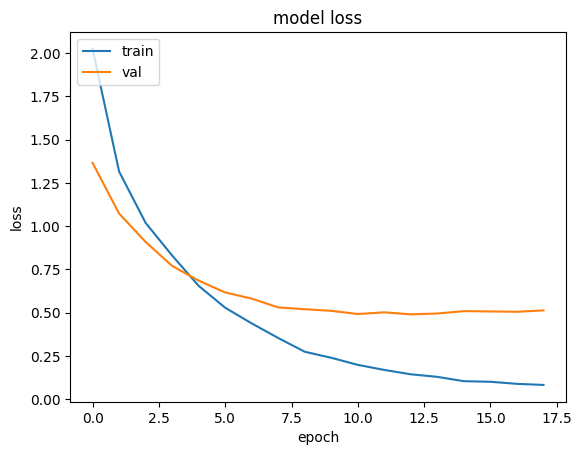

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

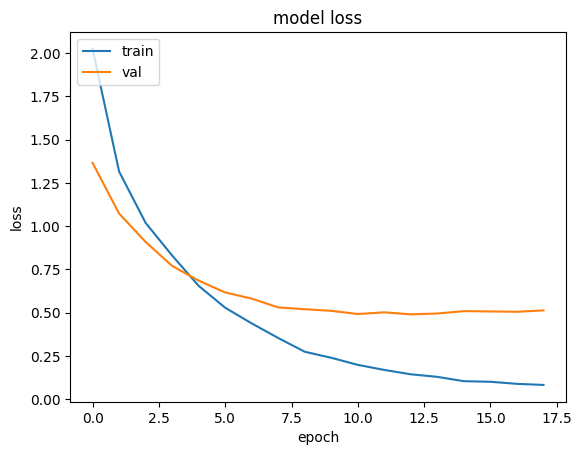

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 16s 58ms/step - loss: 0.5145 - accuracy: 0.8698
Testing: accuracy = 0.869778  ;  loss = 0.514504


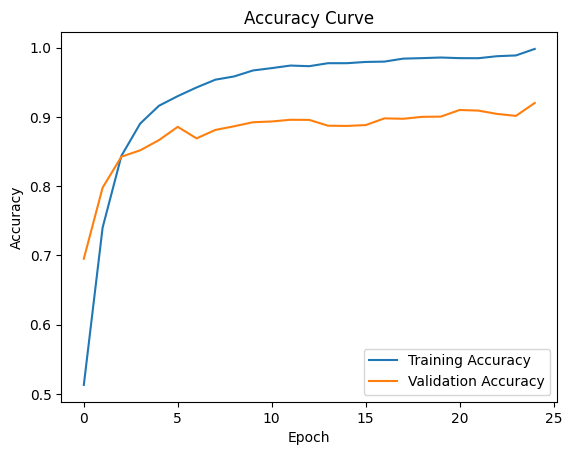

In [ ]:
import matplotlib.pyplot as plt

# Retrieve training history
history = {
    'accuracy': [0.5132, 0.7401, 0.8437, 0.8903, 0.9160, 0.9299, 0.9424, 0.9536, 0.9583, 0.9669, 0.9703, 0.9740, 0.9731, 0.9774, 0.9774, 0.9792, 0.9797, 0.9840, 0.9847, 0.9856, 0.9847, 0.9846, 0.9875, 0.9886,0.998],
    'val_accuracy': [0.6953, 0.7978, 0.8425, 0.8517, 0.8664, 0.8856, 0.8689, 0.8811, 0.8864, 0.8922, 0.8933, 0.8958, 0.8956, 0.8872, 0.8869, 0.8881, 0.8978, 0.8972, 0.9000, 0.9003, 0.9099, 0.909, 0.9042, 0.9014,0.92]
}

# Plot accuracy curve
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

141/141 [==============================] - 8s 32ms/step


<Axes: >

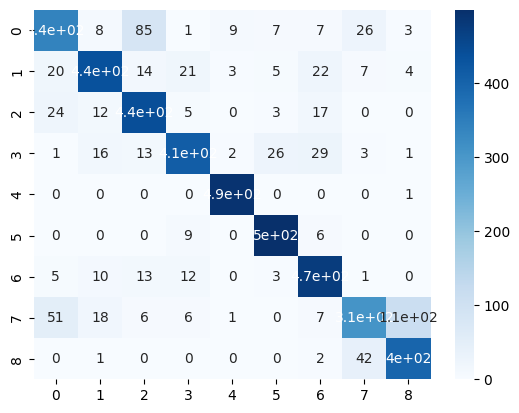

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.8444
Precision: 0.8432
Recall: 0.8449
F1-score: 0.8409
Kappa score: 0.8250


Accuracy: 0.9200
Precision: 0.9213
Recall: 0.9200
F1-score: 0.9288             


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
num_images_per_class = 9

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Create a figure for visualization
fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 15))

for class_label in range(num_classes):
    class_indices = np.where(y_pred == class_label)[0][:num_images_per_class]
    for i, idx in enumerate(class_indices):
        image = x_test[idx]
        true_label = np.argmax(y_test[idx])
        pred_label = y_pred[idx]

        # Display the image with the true and predicted labels
        ax = axes[class_label, i]
        ax.imshow(image)
        ax.set_title(f'True: {label_map[true_label]}\nPred: {label_map[pred_label]}')
        ax.axis('off')

plt.tight_layout()
plt.show()


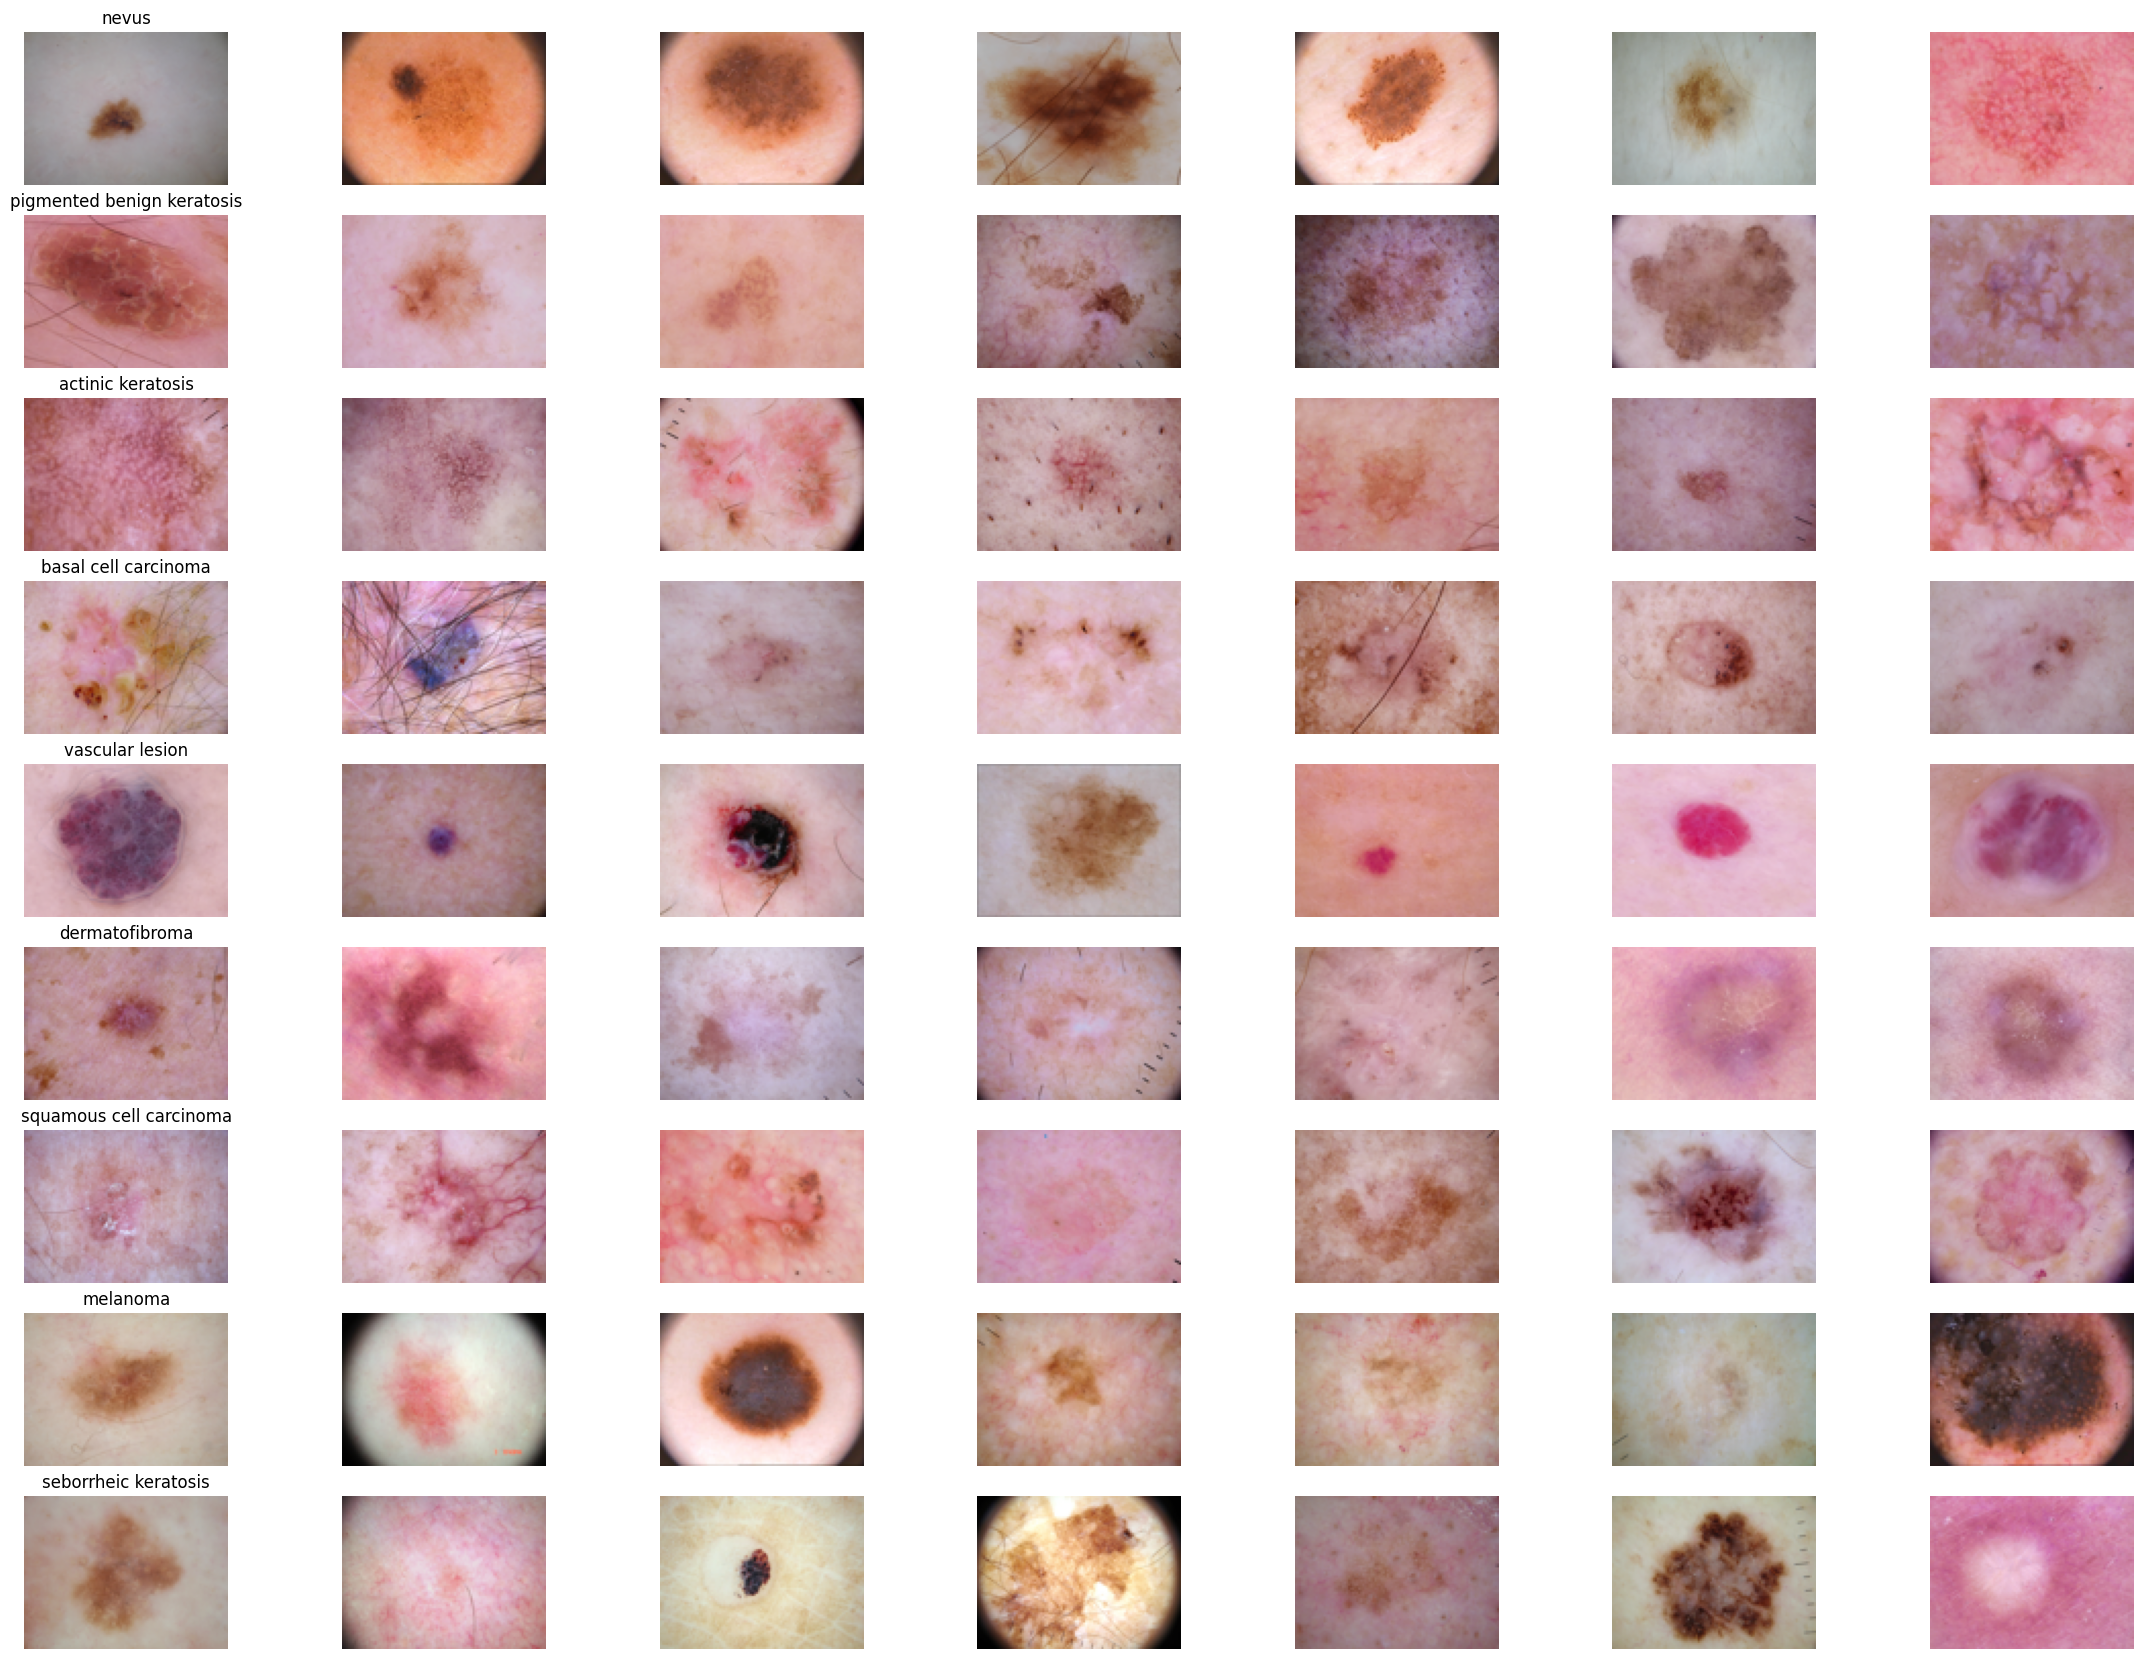

In [ ]:
n_samples = 9
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')